In [1]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import Normalize, ImagePair, RealImage, calculate_overlap, real_data, data_split
import torchvision
from models.generator import GeneratorRRDB
from models.generator_marcel import DeepUResnet

from models.generator_old import GeneratorRRDB as GeneratorRRDB_old
from models.discriminator import Discriminator
from models.feature_extractor import FeatureExtractor

from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
import pytorch_lightning as pl

from torchvision.utils import save_image
from torchsummary import summary
import time
from utils import save_subject, save_subject_all
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import normalized_root_mse as NRMSE
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
std = 0.3548
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [4]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)
# generator_marcel = DeepUResnet(nrfilters=64)
# generator_old = GeneratorRRDB_old(channels=1, filters=64, num_res_blocks=1)
discriminator = Discriminator(input_shape=(1, 64, 64))
feature_extractor = FeatureExtractor()

In [5]:
# img_real = RealImage(number=1, select_slices=None)
# real_subject = [img_real.subject()]
# real_set = tio.SubjectsDataset(
#     real_subject, transform=Normalize(std=std))
#
# real_set[0].plot()

In [6]:
# img_sim = ImagePair(number=100206, select_slices=None, datasource='2mm_1mm')
# sim_subject = [img_sim.subject()]
#
# sim_set = tio.SubjectsDataset(
#     sim_subject, transform=Normalize(std=std))
#
# sim_set[0].plot()

In [5]:
test_subjects = real_data(root_dir='data',
                          numslices=None)
# test_subjects = [test_subjects[0]]

test_set_real = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading real dataset...


In [6]:
test_subjects = data_split('test',
                           patients_frac=.5,
                           datasource='2mm_1mm',
                           numslices=None)
# test_subjects = [test_subjects[0]]

test_set_sim = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading test set...


In [9]:
# source = 'sim'
#
# if source == 'sim':
#     img = sim_set
# elif source == 'real':
#     img = real_set

In [10]:
# ### baseline
# config1 = {
#     'optimizer': 'adam',
#     'b1': 0.9,
#     'b2': 0.5,
#     'batch_size': 16,
#     'num_filters': 64,
#     'learning_rate_G': 1e-4,
#     'learning_rate_D': 1e-4,
#     'patch_size': 64,
#     'alpha_content': 0,
#     'alpha_adversarial': 0.1,
#     'ragan': False,
#     'gan_mode': 'vanilla',
#     'edge_loss': 2,
#     'netD_freq': 1,
#     'datasource': '2mm_1mm',
#     'patients_frac': 0.5,
#     'patch_overlap': 0.5,
# }
#
# root = '/mnt/beta/djboonstoppel/Code'
# exp_name = 'baseline_gan'
# version = 0
# epoch = 55
# ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
# path1 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [11]:
# config1= {
#     'optimizer': 'adam',
#     'b1': 0.9,
#     'b2': 0.5,
#     'batch_size': 16,
#     'num_filters': 64,
#     'learning_rate_G': 1e-4,
#     'learning_rate_D': 1e-5,
#     'patch_size': 64,
#     'alpha_content': 1,
#     'alpha_adversarial': 0.1,
#     'ragan': True,
#     'gan_mode': 'wgan',
#     'edge_loss': 2,
#     'netD_freq': 1,
#     'datasource': '2mm_1mm',
#     'patients_frac': 0.5,
#     'patch_overlap': 0.5,
# }
#
# root = '/mnt/beta/djboonstoppel/Code'
# exp_name = 'disc_lr'
# name = '1e-05'
# epoch = 4
# ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(name, epoch)
# path1 = os.path.join(root, 'ray_results', exp_name, 'checkpoints', ckpt_fname)


In [8]:
config1 = {
    'optimizer': 'adam',
    'b1': 0.9,
    'b2': 0.5,
    'batch_size': 16,
    'num_filters': 64,
    'learning_rate_G': 1e-4,
    'learning_rate_D': 1e-4,
    'patch_size': 64,
    'alpha_content': 0,
    'alpha_adversarial': 0.1,
    'ragan': False,
    'gan_mode': 'vanilla',
    'edge_loss': 2,
    'netD_freq': 1,
    'datasource': '2mm_1mm',
    'patients_frac': 0.5,
    'patch_overlap': 0.5,
}

In [9]:
root = '/mnt/beta/djboonstoppel/Code'
exp_name = 'eroded_mask_10_epoch'
version = 0
epoch = 0
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path1 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [10]:
epoch = 1
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path2 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [11]:
epoch = 2
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path3 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [12]:
epoch = 3
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path4 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [13]:
epoch = 4
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path5 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [14]:
epoch = 5
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path6 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [15]:
epoch = 6
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path7 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [16]:
epoch = 7
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path8 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [17]:
epoch = 8
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path9 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [16]:
# batch_size = 16
#
# patch_size = (64,64)
# ovl_perc = (.5,.5)
# overlap, nr_patches = calculate_overlap(img[0]['LR'], patch_size, ovl_perc)
#
# subject = img[0]
# grid_sampler = tio.inference.GridSampler(
#     subject,
#     patch_size=(*patch_size,1),
#     patch_overlap=overlap,
#     padding_mode=0,
# )
#
# patch_loader = torch.utils.data.DataLoader(
#     grid_sampler, batch_size=16)
#
# configs = [config_bep, config_content, config_gan]
# paths = [path_bep, path_content, path_gan]
# gan = [False, False, True]
#
# for i in range(len(paths)):
#     if gan[i]:
#         model = LitTrainer_gan.load_from_checkpoint(
#             netG=generator,
#             netF=feature_extractor,
#             netD=discriminator,
#             checkpoint_path=paths[i],
#             config=configs[i]
#         )
#     else:
#         model = LitTrainer_org.load_from_checkpoint(
#             netG=generator,
#             netF=feature_extractor,
#             checkpoint_path=paths[i],
#             config=configs[i]
#         )
#     batch_size = model.hparams.config['batch_size']
#
#     patch_size = (model.hparams.config['patch_size'],model.hparams.config['patch_size'])
#     ovl_perc = (model.hparams.config['patch_overlap'], model.hparams.config['patch_overlap'])
#     overlap, nr_patches = calculate_overlap(img[0]['LR'], patch_size, ovl_perc)
#
#     aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
#     with torch.no_grad():
#         for patches_batch in patch_loader:
#             imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
#             gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
#             locations = patches_batch[tio.LOCATION]
#             aggregator.add_batch(gen_hr, locations)
#
#     foreground = aggregator.get_output_tensor()
#     generated = tio.ScalarImage(tensor=foreground)
#     subject.add_image(generated, 'SR'+str(i))
# subject.plot(figsize=(9, 8))
#

In [17]:
# if source == 'sim':
#     img_source = img_sim
# elif source == 'real':
#     img_source = img_real
#
# fname = 'test'
#
# output_path = os.path.join(root, 'output', 'test2')
# os.makedirs(output_path, exist_ok=True)
# std = std
# max_vals = {
#     'LR': img_source.info()['LR']['scaling'],
#     'HR': img_source.info()['HR']['scaling'],
#     'SR': img_source.info()['LR']['scaling'],
# }
# save_subject_all(subject=subject,
#              header=img_source.info()['LR']['header'],
#              pref=fname,
#              std=std,
#              max_vals=max_vals,
#              path=output_path,
#              source = source,
#              )

In [18]:
def NCC(real_image, generated_image):
    """Method to compute the normalised cross correlation between two images.
    Arguments:
                real_image:       (numpy array) the real image
                predicted_image:  (numpy array) the predicted image by the model
    Returns:
                NCCScore:         (float) the normalised cross correlation score
    """
    # if the images are not the same size, raise an error
    if real_image.shape != generated_image.shape:
        raise AssertionError("The inputs must be the same size.")
    # reshape images to vectors
    u = real_image.reshape((real_image.shape[0]*real_image.shape[1]*real_image.shape[2],1))
    v = generated_image.reshape((generated_image.shape[0]*generated_image.shape[1]*real_image.shape[2],1))
    # take the real image and subtract the mean of the real image
    u = u - u.mean(keepdims=True)
    # take the generated image and subtract the mean of the generated image
    v = v - v.mean(keepdims=True)
    # transpose the real image for multiplication
    TransposedU = np.transpose(u)
    # calculate the length of the image
    length = np.linalg.norm(u,ord=2)*np.linalg.norm(v,ord=2)
    # calculate the NCC of the real image and the generated image
    NCCScore = float(TransposedU.dot(v))/length
    # return the NCC score
    return NCCScore

def get_scores(real, gen):
    ncc = NCC(real, gen)
    ssim = SSIM(real.squeeze(), gen.squeeze(), gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
    nrmse = NRMSE(real, gen)
    return ncc, ssim, nrmse

In [19]:
num_checkpoints = 9

batch_size = 16
patch_size = (64,64)
ovl_perc = (.5,.5)
overlap, nr_patches = calculate_overlap(test_set_sim[0]['LR'], patch_size, ovl_perc)

configs = [config1]*num_checkpoints

# configs = [config1, config3, config4, config5]
# paths = [path1, path2, path3, path4, path5]
gan = [True]*num_checkpoints
generators = [generator]*num_checkpoints

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [16:32<00:00, 66.16s/it]
/mnt/beta/djboonstoppel/miniconda/lib/python3.9/site-packages/torchio/visualization.py:103: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/mnt/beta/djboonstoppel/miniconda/lib/python3.9/site-packages/torchio/visualization.py:153: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


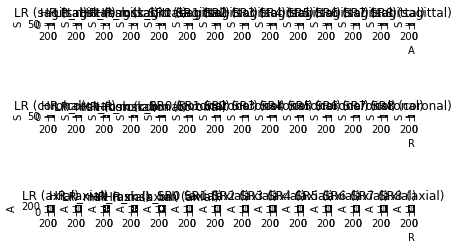

In [20]:
test_subjects_new_sim = []
for subject in tqdm(test_set_sim):
    grid_sampler = tio.inference.GridSampler(
        subject,
        patch_size=(*patch_size,1),
        patch_overlap=overlap,
        padding_mode=0,
    )

    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=16)

    for i in range(num_checkpoints):
        if gan[i]:
            model = LitTrainer_gan.load_from_checkpoint(
                netG=generators[i],
                netF=feature_extractor,
                netD=discriminator,
                checkpoint_path=globals()['path' + str(i+1)],
                config=configs[i]
            )
        else:
            model = LitTrainer_org.load_from_checkpoint(
                netG=generators[i],
                netF=feature_extractor,
                checkpoint_path=globals()['path' + str(i+1)],
                config=configs[i]
            )

        model.to(device)
        model.eval()

        aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')

        with torch.no_grad():
            for patches_batch in patch_loader:
                imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
                gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
                locations = patches_batch[tio.LOCATION]
                aggregator.add_batch(gen_hr, locations)

        foreground = aggregator.get_output_tensor()
        generated = tio.ScalarImage(tensor=foreground)
        subject.add_image(generated, 'SR'+str(i))
    test_subjects_new_sim.append(subject)
test_subjects_new_sim[0].plot()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:59<00:00, 59.95s/it]


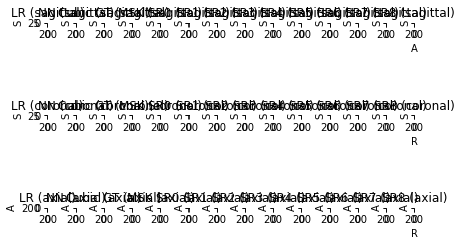

In [21]:
test_subjects_new_real = []
for subject in tqdm(test_set_real):
    grid_sampler = tio.inference.GridSampler(
        subject,
        patch_size=(*patch_size,1),
        patch_overlap=overlap,
        padding_mode=0,
    )

    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=16)

    for i in range(num_checkpoints):
        if gan[i]:
            model = LitTrainer_gan.load_from_checkpoint(
                netG=generators[i],
                netF=feature_extractor,
                netD=discriminator,
                checkpoint_path=globals()['path' + str(i+1)],
                config=configs[i]
            )
        else:
            model = LitTrainer_org.load_from_checkpoint(
                netG=generators[i],
                netF=feature_extractor,
                checkpoint_path=globals()['path' + str(i+1)],
                config=configs[i]
            )

        model.to(device)
        model.eval()

        aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
        with torch.no_grad():
            for patches_batch in patch_loader:
                imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['GT'][tio.DATA].squeeze(4)
                gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
                locations = patches_batch[tio.LOCATION]
                aggregator.add_batch(gen_hr, locations)

        foreground = aggregator.get_output_tensor()
        generated = tio.ScalarImage(tensor=foreground)
        subject.add_image(generated, 'SR'+str(i))
    test_subjects_new_real.append(subject)
test_subjects_new_real[0].plot()

In [22]:
def post_proc(img:torch.Tensor, bg_idx:np.ndarray, crop_coords:tuple) -> np.ndarray:
    img[bg_idx] = 0
    min, max = crop_coords
    img = img.squeeze(0)[min[0]:max[0]+1, min[1]:max[1]+1, min[2]:max[2]+1].numpy()*std
    return img

In [23]:
metrics = ['NCC', 'SSIM', 'NRMSE']
scores_real = {key:{'SR'+str(num):[] for num in range(num_checkpoints)} for key in metrics}

calc_interpolations = True
interpolations = ['Cubic']
if calc_interpolations:
    for key in metrics:
        for interp in interpolations:
            scores_real[key][interp] = []

for i in range(len(test_subjects_new_real)):
    mask = test_subjects_new_real[i]['MSK'].data

    bg_idx = np.where(mask==0)
    brain_idx = np.where(mask.squeeze(0)!=0)
    crop_coords = ([brain_idx[i].min() for i in range(len(brain_idx))],
                   [brain_idx[i].max() for i in range(len(brain_idx))])

    HR = post_proc(test_subjects_new_real[i]['GT'].data, bg_idx, crop_coords)
    if calc_interpolations:
        for interp in interpolations:
            img_int = post_proc(test_subjects_new_real[i][interp].data, bg_idx, crop_coords)
            ncc, ssim, nrmse = get_scores(HR, img_int)
            scores_real['NCC'][interp].append(ncc)
            scores_real['SSIM'][interp].append(ssim)
            scores_real['NRMSE'][interp].append(nrmse)

    for j in range(num_checkpoints):
        SR = post_proc(test_subjects_new_real[i]['SR' + str(j)].data, bg_idx, crop_coords)
        ncc, ssim, nrmse = get_scores(HR, SR)

        scores_real['NCC']['SR' + str(j)].append(ncc)
        scores_real['SSIM']['SR' + str(j)].append(ssim)
        scores_real['NRMSE']['SR' + str(j)].append(nrmse)

In [24]:
metrics = ['NCC', 'SSIM', 'NRMSE']
scores_simulated = {key:{'SR'+str(num):[] for num in range(num_checkpoints)} for key in metrics}

for i in range(len(test_subjects_new_sim)):
    mask = test_subjects_new_sim[i]['HR_msk'].data

    bg_idx = np.where(mask==0)
    brain_idx = np.where(mask.squeeze(0)!=0)
    crop_coords = ([brain_idx[i].min() for i in range(len(brain_idx))],
                   [brain_idx[i].max() for i in range(len(brain_idx))])


    HR   = post_proc(test_subjects_new_sim[i]['HR'].data, bg_idx, crop_coords)

    for j in range(num_checkpoints):
        SR = post_proc(test_subjects_new_sim[i]['SR' + str(j)].data, bg_idx, crop_coords)
        ncc, ssim, nrmse = get_scores(HR, SR)

        scores_simulated['NCC']['SR' + str(j)].append(ncc)
        scores_simulated['SSIM']['SR' + str(j)].append(ssim)
        scores_simulated['NRMSE']['SR' + str(j)].append(nrmse)

In [25]:
labels_sim = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
labels_real = labels_sim + ['Cubic']

path = 'figs/time'
os.makedirs(path, exist_ok=True)
fig_size = [8,4]
fname = 'epoch_9_adv'

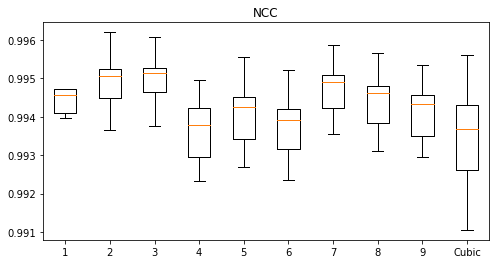

In [26]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('NCC')
ax.boxplot(scores_real['NCC'].values(), showfliers=False)
ax.set_xticklabels(labels_real)
fig.savefig(os.path.join(path, fname+'_real_NCC'), dpi=240)

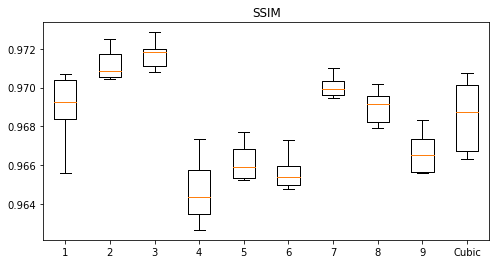

In [27]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('SSIM')
ax.boxplot(scores_real['SSIM'].values(), showfliers=False)
ax.set_xticklabels(labels_real)
fig.savefig(os.path.join(path, fname+'_real_SSIM'), dpi=240)

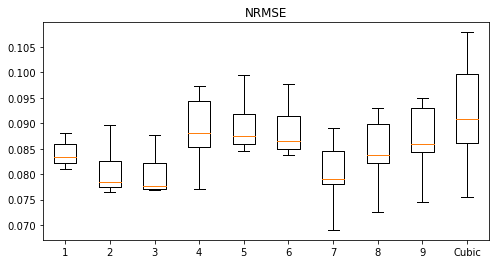

In [28]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('NRMSE')
ax.boxplot(scores_real['NRMSE'].values(), showfliers=False)
ax.set_xticklabels(labels_real)
fig.savefig(os.path.join(path, fname+'_real_NRMSE'), dpi=240)

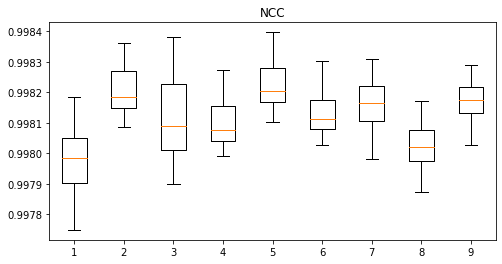

In [29]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('NCC')
ax.boxplot(scores_simulated['NCC'].values(), showfliers=False)
ax.set_xticklabels(labels_sim)
fig.savefig(os.path.join(path, fname+'_sim_NCC'), dpi=240)

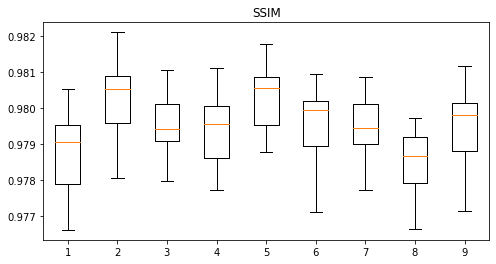

In [30]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('SSIM')
ax.boxplot(scores_simulated['SSIM'].values(), showfliers=False)
ax.set_xticklabels(labels_sim)
fig.savefig(os.path.join(path, fname+'_sim_SSIM'), dpi=240)

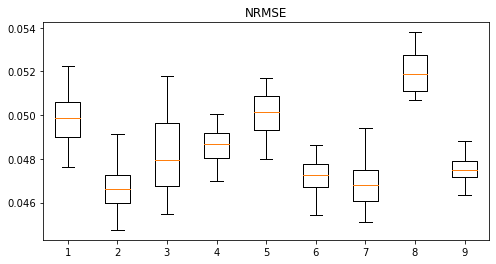

In [31]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('NRMSE')
ax.boxplot(scores_simulated['NRMSE'].values(), showfliers=False)
ax.set_xticklabels(labels_sim)
fig.savefig(os.path.join(path, fname+'_sim_NRMSE'), dpi=240)

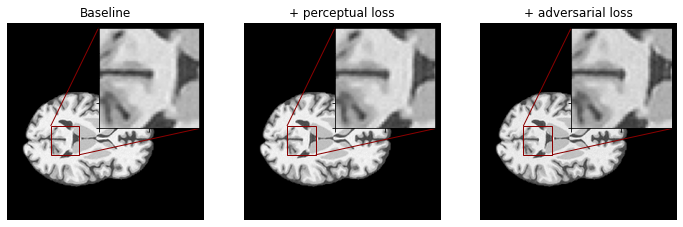

In [29]:
img_slice0 = test_subjects_new_sim[0]['SR0'].data[0,:,:,35].numpy()*std
img_slice1 = test_subjects_new_sim[0]['SR1'].data[0,:,:,35].numpy()*std
img_slice2 = test_subjects_new_sim[0]['SR2'].data[0,:,:,35].numpy()*std

fig, axes = plt.subplots(1,3, figsize=[12,4])
fig.set_facecolor('white')
imgs = [img_slice0, img_slice1, img_slice2]
titles = ['Baseline', '+ perceptual loss', '+ adversarial loss']
for i, axis in enumerate(axes):
    axis.set_axis_off()
    axis.set_title(titles[i])
    x1, x2, y1, y2 = 60, 100, 90, 130

    axis.imshow(np.pad(imgs[i], (0,50), 'edge'), origin="lower", cmap='gray', vmin=0, vmax=1.1)
    axins = zoomed_inset_axes(axis, 3.5, loc=1) # zoom = 3.5
    axins.imshow(imgs[i],cmap='gray', vmin=0, vmax=1.2)#, interpolation='bicubic')
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec='darkred', lw=1)
# plt.draw()
# plt.show()
# fig.savefig('figs/Sim_results_v2.png', dpi=300, bbox_inches='tight')

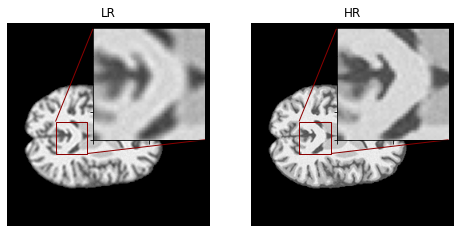

In [15]:
img_slice0 = test_subjects_new_sim[0]['LR'].data[0,:,:,35].numpy()*std
img_slice1 = test_subjects_new_sim[0]['HR'].data[0,:,:,35].numpy()*std

fig, axes = plt.subplots(1,2, figsize=[8,4])
fig.set_facecolor('white')
imgs = [img_slice0, img_slice1]
titles = ['LR', 'HR']
for i, axis in enumerate(axes):
    axis.set_axis_off()
    axis.set_title(titles[i])
    x1, x2, y1, y2 = 60, 100, 90, 130

    axis.imshow(np.pad(imgs[i], (0,30), 'edge'), origin="lower", cmap='gray', vmin=0, vmax=1.1)
    axins = zoomed_inset_axes(axis, 3.5, loc=1) # zoom = 3.5
    axins.imshow(imgs[i], cmap='gray', vmin=0, vmax=1.2)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec='darkred', lw=1)
# fig.savefig('figs/Sim_org_v2', dpi=300, bbox_inches='tight')

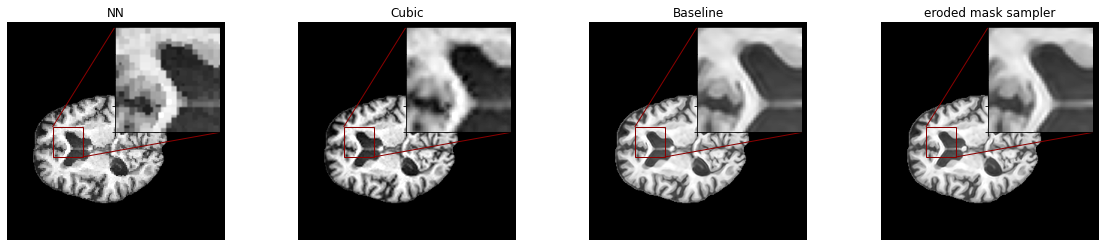

In [30]:
img_slice0 = test_subjects_new_real[1]['NN'].data[0,:,:,24].numpy()*std
img_slice1 = test_subjects_new_real[1]['Cubic'].data[0,:,:,24].numpy()*std
img_slice2 = test_subjects_new_real[1]['SR0'].data[0,:,:,24].numpy()*std
img_slice3 = test_subjects_new_real[1]['SR1'].data[0,:,:,24].numpy()*std
# img_slice4 = test_subjects_new_real[0]['SR2'].data[0,:,:,24].numpy()*std

fig, axes = plt.subplots(1,4, figsize=[20,4])
fig.set_facecolor('white')
imgs = [img_slice0, img_slice1, img_slice2, img_slice3]#, img_slice4]
titles = ['NN', 'Cubic', 'Baseline', 'eroded mask sampler']
for i, axis in enumerate(axes):
    axis.set_axis_off()
    axis.set_title(titles[i])
    x1, x2, y1, y2 = 60, 100, 110, 150

    axis.imshow(np.pad(imgs[i], (0,50), 'edge'), origin="lower", cmap='gray', vmin=0, vmax=1.2)
    axins = zoomed_inset_axes(axis, 3.5, loc=1) # zoom = 3.5
    axins.imshow(imgs[i],cmap='gray', vmin=0, vmax=1.3)#, interpolation='bicubic')
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec='darkred', lw=1)
# plt.draw()
# plt.show()
# fig.savefig('figs/test.png', dpi=300, bbox_inches='tight')

In [32]:
img_sim = ImagePair(number=100206, select_slices=None, datasource='2mm_1mm')
subject = img_sim.subject()
header = img_sim.info()['HR']['header']
max_vals = {
    'LR': img_sim.info()['LR']['scaling'],
    'HR': img_sim.info()['HR']['scaling'],
    'SR': img_sim.info()['LR']['scaling'],
}

In [34]:
img_real = RealImage(number=1, select_slices=None)
subject = img_real.subject()
header = img_real.info()['GT']['header']
max_vals = {
    'LR': img_real.info()['LR']['scaling'],
    'GT': img_real.info()['GT']['scaling'],
    'NN': img_real.info()['GT']['scaling'],
    'Cu': img_real.info()['GT']['scaling'],
    'MS': img_real.info()['GT']['scaling'],
    'SR': img_real.info()['LR']['scaling'],
}

In [35]:
# test_subjects_new_real[0].plot()
save_subject_all(subject = test_subjects_new_real[0],
                 header = header,
                 pref = 'real_epoch_9_adv',
                 std = std,
                 max_vals = max_vals,
                 source = 'real',
                 path = 'output/eroded_mask/time')

LR
NN
Cubic
GT
MSK
SR0
SR1
SR2
SR3
SR4
SR5
SR6
SR7
SR8
